# Lab Assignment Three: Extending Logistic Regression

### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng


### 1. Preparation and Overview

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm import tqdm

raw_data = pd.read_csv("data/bodyPerformance.csv")

# preprocessing
data = pd.get_dummies(raw_data, columns=['gender'],dtype=np.int8) # one-hot encoding for gender
labels = data['class'].map(lambda c: ord(c) - ord('A')) # encode lables into integer
data.drop(['class'], axis=1, inplace=True) # remove class column

# scale
scaler = StandardScaler()
features = scaler.fit_transform(data)

# PCA
pca = PCA(8)
pca_feature = pca.fit_transform(features)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_feature, labels, train_size=0.8)
print(pca_feature.shape, X_train.shape, X_test.shape,  y_train.shape, y_test.shape)

(13393, 8) (10714, 8) (2679, 8) (10714,) (2679,)


In [35]:
# test different folds of cross validation
cross_validation_accs = {}
# n fold cross-validation, n: 2-20
for n in tqdm(range(3, 11)):
    # n-fold cross-validation
    cross_validator = KFold(n_splits=n)
    split_indices = cross_validator.split(features, labels)
    
    # training and testing
    avg_accs = []
    for train_indices, test_indices in split_indices:
        X_train, y_train = features[train_indices], labels[train_indices]
        X_test, y_test = features[test_indices], labels[test_indices]
        
        classifier = SVC()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        avg_accs.append(acc)
    
    cross_validation_accs[n] = avg_accs

100%|██████████| 8/8 [02:08<00:00, 16.01s/it]


Text(0.5, 1.0, 'Cross Validation Accuracies')

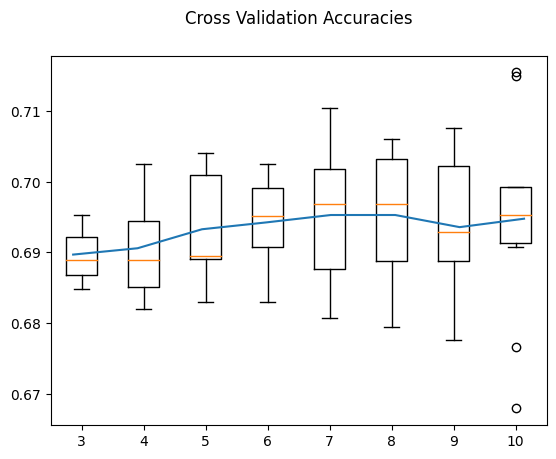

In [36]:
# plot cross validation accuracies
plt.boxplot(cross_validation_accs.values(), labels=list(range(3, 11)))
ax = plt.twiny()
avg_accs = [np.mean(accs) for accs in cross_validation_accs.values()]
ax.plot(avg_accs)
ax.set_axis_off()
plt.title("Cross Validation Accuracies")

According to the graph above, it is clear that the 7-fold cross-validation has the best accuracies. Hence, a rougly 86/14 split would be ideal for this dataset.

In [ ]:
# use the optimal number of folds
cross_validator = KFold(n_splits=7)
split_indices = cross_validator.split(features, labels)

References: